In [175]:
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

font = {"family": "YuGothic"}
matplotlib.rc("font", **font)

In [176]:
client60_single = pd.read_csv("../log-single-client60/nginx-minis2.csv")
client60_single = client60_single.select_dtypes(include=['int', 'float'])
client60_single_h2_start = client60_single["Time"].min() + 30
client60_single_h2_end = 1675605220 - 30
client60_single_h3_start = 1675605833 + 30
client60_single_h3_end = client60_single["Time"].max() -30
client60_single.dtypes

Time         int64
UID          int64
PID          int64
%usr       float64
%system    float64
%guest     float64
%wait      float64
%CPU       float64
CPU          int64
dtype: object

In [177]:
client60_simple = pd.read_csv("../log-simple-client60/nginx-minis2.csv")
client60_simple = client60_simple.select_dtypes(include=["int", "float"])
client60_simple_h2_start = client60_simple["Time"].min() + 30
client60_simple_h2_end = 1675601408 - 30
client60_simple_h3_start = 1675602012 + 30
client60_simple_h3_end = client60_simple["Time"].max() - 30
client60_simple.dtypes


Time         int64
UID          int64
PID          int64
%usr       float64
%system    float64
%guest     float64
%wait      float64
%CPU       float64
CPU          int64
dtype: object

In [178]:
def cpu_performance(df: pd.DataFrame, start: int, end: int):
    df_groupby = df[(start <= df["Time"]) & (df["Time"] <= end)].groupby("Time")
    df_groupby = df_groupby.sum()
    return df_groupby


In [179]:
client60_single_h2 = cpu_performance(client60_single, client60_single_h2_start, client60_single_h2_end)
des_single_h2 = client60_single_h2[[r"%usr", r"%system", r"%CPU"]].describe()
des_single_h2.to_csv("server-single-h2.csv")
client60_single_h3 = cpu_performance(client60_single, client60_single_h3_start, client60_single_h3_end)
des_single_h3 = client60_single_h3[[r"%usr", r"%system", r"%CPU"]].describe()
des_single_h3.to_csv("server-single-h3.csv")
result_single = pd.DataFrame()
result_single["HTTP/2\n/single.html"] = client60_single_h2[r"%CPU"].reset_index(drop=True)
result_single["HTTP/3\n/single.html"] = client60_single_h3[r"%CPU"].reset_index(drop=True)
result_single.to_csv("server-describe.csv", index=False)
result_single

,HTTP/2\n/single.html,HTTP/3\n/single.html
0,10.0,61.0
1,31.0,53.0
2,8.0,59.0
3,14.0,58.0
4,18.0,68.0
...,...,...
1890,11.0,58.0
1891,13.0,54.0
1892,22.0,60.0
1893,17.0,55.0


In [180]:
client60_simple_h2 = cpu_performance(client60_simple, client60_simple_h2_start, client60_simple_h2_end)
des_simple_h2 = client60_simple_h2[[r"%usr", r"%system", r"%CPU"]].describe()
des_simple_h2.to_csv("server-simple-h2.csv")
client60_simple_h3 = cpu_performance(client60_simple, client60_simple_h3_start, client60_simple_h3_end)
des_simple_h3 = client60_simple_h3[[r"%usr", r"%system", r"%CPU"]].describe()
des_simple_h3.to_csv("server-simple-h3.csv")
result_simple = pd.DataFrame()
result_simple["HTTP/2\n/simple.html"] = client60_simple_h2[r"%CPU"].reset_index(drop=True)
result_simple["HTTP/3\n/simple.html"] = client60_simple_h3[r"%CPU"].reset_index(drop=True)
result_simple.to_csv("server-describe.csv", index=False)
result_simple


,HTTP/2\n/simple.html,HTTP/3\n/simple.html
0,34.0,36.0
1,35.0,32.0
2,34.0,35.0
3,32.0,39.0
4,31.0,37.0
...,...,...
280,31.0,39.0
281,34.0,33.0
282,32.0,33.0
283,34.0,40.0


In [181]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 6))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
result = pd.concat([result_simple, result_single], axis=1)


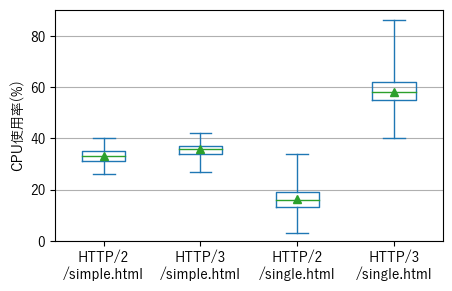

In [182]:
plot = result.plot.box(
    showmeans=True, ylabel="CPU使用率(%)", figsize=(5, 3), whis=[0, 100]
)
plot.set_ylim(0)
plot.grid(which="major", axis="y")
